# Malware classification using Machine Learning

## Install library

In [1]:
# !pip install numpy
# !pip install pandas
# !pip install scikit-learn
# !pip install matplotlib

## 1. Import thư viện

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

## 2. Load Dataset

In [3]:
data = pd.read_csv('../../dataset/dataset.csv')

In [4]:
data = data.drop('PackerType',axis=1)
data = data.drop('MD5',axis=1)

In [5]:
data.head()

,e_magic,e_cblp,e_cp,e_crlc,e_cparhdr,e_minalloc,e_maxalloc,e_ss,e_sp,e_csum,...,SuspiciousSections,NonSuspiciousSections,PackerDetected,TextEntropy,DataEntropy,FileSize,FileEntropy,ImportCount,ExportCount,Label
0,23117,144,3,0,4,0,65535,0,184,0,...,3,0,1,6.099207,0.0,48640,0.000320,1,0,0
1,23117,144,3,0,4,0,65535,0,184,0,...,3,0,1,5.234672,0.0,20480,0.000699,1,0,0
2,23117,144,3,0,4,0,65535,0,184,0,...,3,0,1,5.997410,0.0,54328,0.000290,1,0,0
3,23117,144,3,0,4,0,65535,0,184,0,...,2,0,0,5.060352,0.0,40960,0.000374,0,0,0
4,23117,144,3,0,4,0,65535,0,184,0,...,3,0,1,5.410964,0.0,21504,0.000669,1,0,0


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16773 entries, 0 to 16772
Data columns (total 59 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   e_magic                      16773 non-null  int64  
 1   e_cblp                       16773 non-null  int64  
 2   e_cp                         16773 non-null  int64  
 3   e_crlc                       16773 non-null  int64  
 4   e_cparhdr                    16773 non-null  int64  
 5   e_minalloc                   16773 non-null  int64  
 6   e_maxalloc                   16773 non-null  int64  
 7   e_ss                         16773 non-null  int64  
 8   e_sp                         16773 non-null  int64  
 9   e_csum                       16773 non-null  int64  
 10  e_ip                         16773 non-null  int64  
 11  e_cs                         16773 non-null  int64  
 12  e_lfarlc                     16773 non-null  int64  
 13  e_ovno          

In [7]:
print('Số lượng mẫu lành tính là:', data.groupby(data['Label']).size()[0])
print('Số lượng mẫu độc hại là:', data.groupby(data['Label']).size()[1])

Số lượng mẫu lành tính là: 7811
Số lượng mẫu độc hại là: 8962


### Sử dụng 75% dataset để train, 25% để test 

In [8]:
new_data = data.iloc[:, :-1].values
labels = data['Label'].values
X_train, X_test, Y_train, Y_test = train_test_split(new_data, labels, test_size=0.25)

## 3. Training

### 3.1 - Decision Tree

In [9]:
# Định nghĩa lưới tham số
param_grid = {
    'criterion': ['gini', 'entropy'],  
    'max_depth': [None, 3, 5, 10],
    'min_samples_split': [2, 5, 10],  
    'min_samples_leaf': [1, 2, 5]
}

# GridSearchCV
grid_search = GridSearchCV(estimator=DecisionTreeClassifier(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, Y_train)
print("Tham số tối ưu:", grid_search.best_params_)

Tham số tối ưu: {'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}



Báo cáo về kết quả phân loại:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1946
           1       1.00      1.00      1.00      2248

    accuracy                           1.00      4194
   macro avg       1.00      1.00      1.00      4194
weighted avg       1.00      1.00      1.00      4194

Độ chính xác của thuật toán:  99.66618979494515


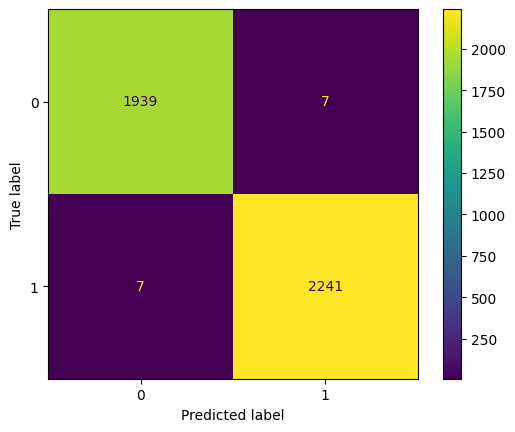

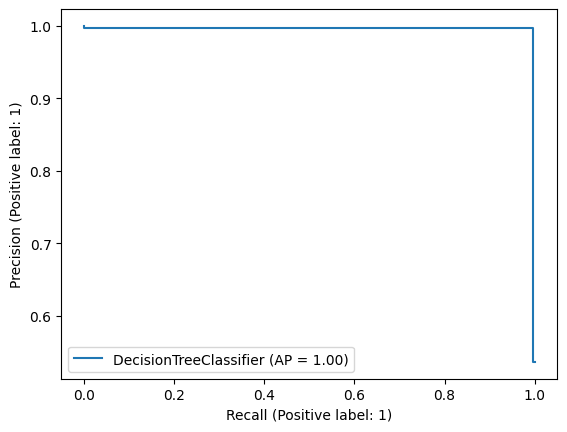

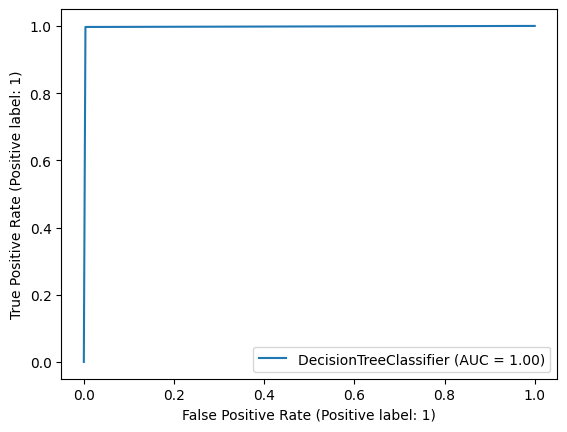

In [10]:
dtModel = grid_search.best_estimator_

y_pred = dtModel.predict(X_test)
print("\nBáo cáo về kết quả phân loại:\n", classification_report(Y_test, y_pred))
# Độ chính xác của thuật toán
accuracy = accuracy_score(Y_test, y_pred)
print("Độ chính xác của thuật toán: ", accuracy * 100)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(dtModel, X_test, Y_test)

# Đồ thị Precision-Recall (PR)
PrecisionRecallDisplay.from_estimator(dtModel, X_test, Y_test)

# Biểu đồ đường cong ROC (Receiver Operating Characteristic)
RocCurveDisplay.from_estimator(dtModel, X_test, Y_test)

### 3.2 - Random Forest

In [11]:
# Khởi tạo mô hình Random Forest
rf = RandomForestClassifier(random_state=42)

# Tuning tham số với GridSearchCV
param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
}

# Sử dụng GridSearchCV để tìm tham số tối ưu
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_train, Y_train)
print("Tham số tối ưu:", grid_search.best_params_)

Tham số tối ưu: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}



Báo cáo về kết quả phân loại:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1946
           1       1.00      1.00      1.00      2248

    accuracy                           1.00      4194
   macro avg       1.00      1.00      1.00      4194
weighted avg       1.00      1.00      1.00      4194

Độ chính xác của thuật toán:  99.83309489747259


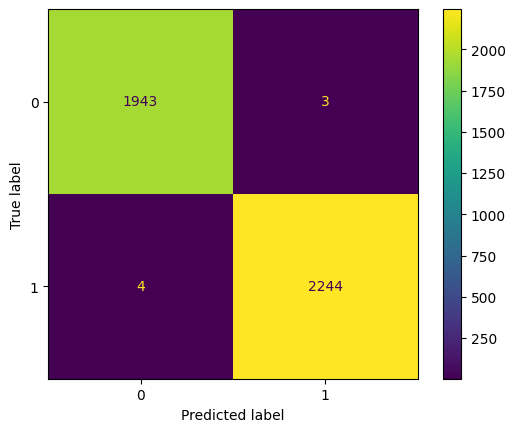

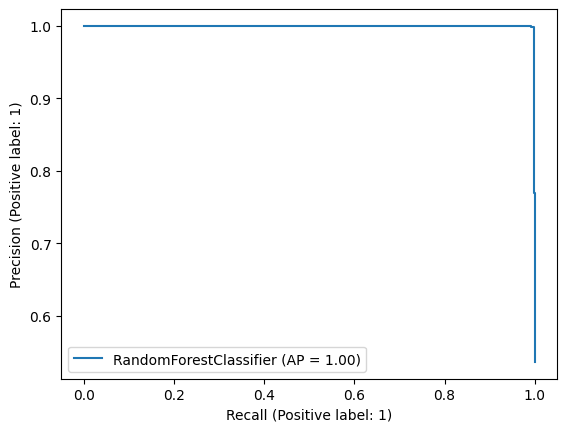

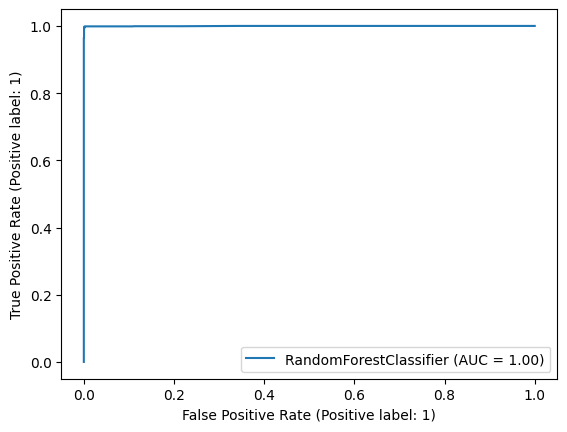

In [12]:
rfModel = grid_search.best_estimator_

y_pred = rfModel.predict(X_test)
print("\nBáo cáo về kết quả phân loại:\n", classification_report(Y_test, y_pred))
# Độ chính xác của thuật toán
accuracy = accuracy_score(Y_test, y_pred)
print("Độ chính xác của thuật toán: ", accuracy * 100)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(rfModel, X_test, Y_test)

# Đồ thị Precision-Recall (PR)
PrecisionRecallDisplay.from_estimator(rfModel, X_test, Y_test)

# Biểu đồ đường cong ROC (Receiver Operating Characteristic)
RocCurveDisplay.from_estimator(rfModel, X_test, Y_test)

### 3.3 -  KNN (K Nearest Neighbors)

In [13]:
param_grid = {'n_neighbors': [3, 5, 7, 10, 12, 15, 18]}
grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5)
grid.fit(X_train, Y_train)
print("Tham số tối ưu:", grid_search.best_params_)

Tham số tối ưu: {'bootstrap': False, 'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}



Báo cáo về kết quả phân loại:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      1946
           1       0.98      0.97      0.98      2248

    accuracy                           0.97      4194
   macro avg       0.97      0.97      0.97      4194
weighted avg       0.97      0.97      0.97      4194

Độ chính xác của thuật toán:  97.35336194563662


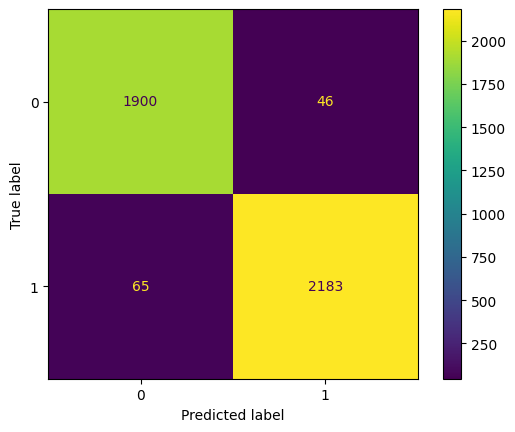

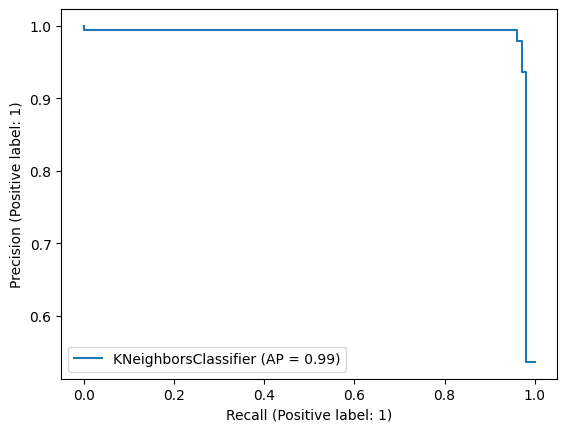

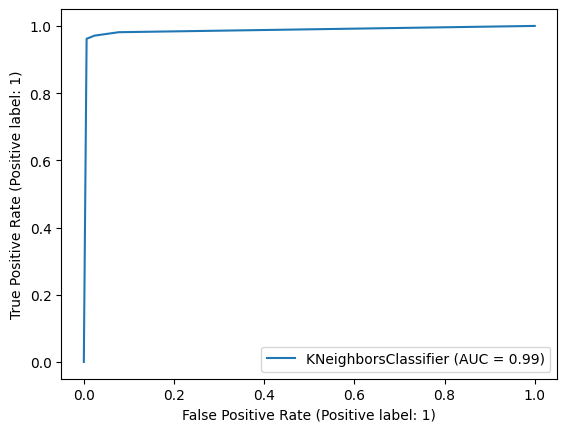

In [14]:
# Chọn tham số K
k = grid.best_params_['n_neighbors']
knnModel = KNeighborsClassifier(n_neighbors=k)

# Train mô hình
knnModel.fit(X_train, Y_train)

# Dự đoán trên tập test
y_pred = knnModel.predict(X_test)
print("\nBáo cáo về kết quả phân loại:\n", classification_report(Y_test, y_pred))
# Độ chính xác của thuật toán
accuracy = accuracy_score(Y_test, y_pred)
print("Độ chính xác của thuật toán: ", accuracy * 100)

# Confusion matrix
ConfusionMatrixDisplay.from_estimator(knnModel, X_test, Y_test)

# Đồ thị Precision-Recall (PR)
PrecisionRecallDisplay.from_estimator(knnModel, X_test, Y_test)

# Biểu đồ đường cong ROC (Receiver Operating Characteristic)
RocCurveDisplay.from_estimator(knnModel, X_test, Y_test)

## 5. Export Model

In [15]:
import joblib

joblib.dump(dtModel, '../../models/decision_tree_model.pkl')
joblib.dump(knnModel, '../../models/random_forest_model.pkl')
joblib.dump(rfModel, '../../models/K-nearestNeighbors.pkl')

['../../models/K-nearestNeighbors.pkl']